Mounted at /content/drive
Top 10 keywords based on Helpfulness > 0.5: ['dvd' 'film' 'good' 'great' 'just' 'like' 'movie' 'really' 'story' 'time']


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:57:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacking Classifier Accuracy: 56.14%


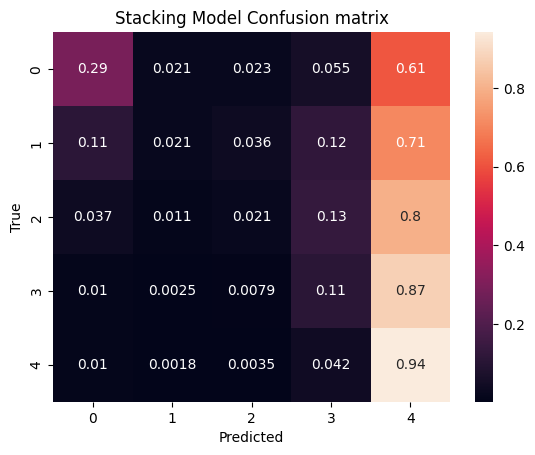

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset from Google Drive
trainingSet = pd.read_csv("/content/drive/MyDrive/CS506/data/train.csv")
testingSet = pd.read_csv("/content/drive/MyDrive/CS506/data/test.csv")

# Function to add custom features and extract top keywords dynamically
def add_features_to(df, top_n_keywords=10):
    # Create Helpfulness column and handle missing values
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Filter rows where Helpfulness > 0.5
    filtered_df = df[df['Helpfulness'] > 0.5]

    # Extract text data from filtered rows
    text_data = filtered_df['Text'].dropna().tolist()

    # Use CountVectorizer to find the most frequent words in the 'Text' column
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n_keywords)
    X_text = vectorizer.fit_transform(text_data)

    # Get the top n keywords
    keywords = vectorizer.get_feature_names_out()

    print(f"Top {top_n_keywords} keywords based on Helpfulness > 0.5: {keywords}")

    # Add algorithmically generated keyword presence as features to the dataframe
    for keyword in keywords:
        df[f'contains_{keyword}'] = df['Text'].apply(lambda x: 1 if pd.notnull(x) and keyword in x.lower() else 0)

    # Manually selected keywords
    manual_keywords = ['love', 'great', 'recommend', 'best', 'favorite', 'worst', 'awful', 'terrific']

    # Add manually selected keyword presence as features to the dataframe
    for keyword in manual_keywords:
        df[f'contains_{keyword}'] = df['Text'].apply(lambda x: 1 if pd.notnull(x) and keyword in x.lower() else 0)

    # Combine both algorithmic and manual keywords
    all_keywords = list(keywords) + manual_keywords

    # Additional features: review length
    df['review_length'] = df['Text'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

    return df, all_keywords

# Load the feature extracted files if they've already been generated
if exists('/content/drive/MyDrive/CS506/data/X_train.csv'):
    X_train = pd.read_csv("/content/drive/MyDrive/CS506/data/X_train.csv")
if exists('/content/drive/MyDrive/CS506/data/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/MyDrive/CS506/data/X_submission.csv")

else:
    # Process the DataFrame and extract top keywords
    train, top_keywords = add_features_to(trainingSet, top_n_keywords=10)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null and helpfulness is above 0.5
    X_train = train[train['Score'].notnull() & (train['Helpfulness'] > 0.5)]

    X_submission.to_csv("/content/drive/MyDrive/CS506/data/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/MyDrive/CS506/data/X_train.csv", index=False)

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Select features for base and stacking models
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'review_length'] + \
           [f'contains_{keyword}' for keyword in top_keywords]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# First Level: Train Gradient Boosting, Random Forest, and Logistic Regression
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)  # Reduced number of estimators
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)      # Reduced number of estimators
lr_clf = LogisticRegression(max_iter=1000, random_state=42)             # Added Logistic Regression

# 3-fold cross-validation
cv_folds = 3

# Get predictions (probabilities) from the first-level models
gb_pred = cross_val_predict(gb_clf, X_train_select, Y_train, cv=cv_folds, method='predict_proba')
rf_pred = cross_val_predict(rf_clf, X_train_select, Y_train, cv=cv_folds, method='predict_proba')
lr_pred = cross_val_predict(lr_clf, X_train_select, Y_train, cv=cv_folds, method='predict_proba')

# Stack predictions as new features for the meta-model (XGBoost)
stacked_predictions = pd.DataFrame({
    'gb_1': gb_pred[:, 0],
    'gb_2': gb_pred[:, 1],
    'gb_3': gb_pred[:, 2],
    'gb_4': gb_pred[:, 3],
    'gb_5': gb_pred[:, 4],
    'rf_1': rf_pred[:, 0],
    'rf_2': rf_pred[:, 1],
    'rf_3': rf_pred[:, 2],
    'rf_4': rf_pred[:, 3],
    'rf_5': rf_pred[:, 4],
    'lr_1': lr_pred[:, 0],
    'lr_2': lr_pred[:, 1],
    'lr_3': lr_pred[:, 2],
    'lr_4': lr_pred[:, 3],
    'lr_5': lr_pred[:, 4]
})

# Meta Model: XGBClassifier
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the meta model on the stacked predictions
meta_model.fit(stacked_predictions, Y_train - 1)  # Adjust labels to start from 0

# First Level: Train individual models on full data
gb_clf.fit(X_train_select, Y_train)
rf_clf.fit(X_train_select, Y_train)
lr_clf.fit(X_train_select, Y_train)

# Get predictions from first-level models on the test set
gb_test_pred = gb_clf.predict_proba(X_test_select)
rf_test_pred = rf_clf.predict_proba(X_test_select)
lr_test_pred = lr_clf.predict_proba(X_test_select)

# Stack test set predictions for the meta-model
stacked_test_predictions = pd.DataFrame({
    'gb_1': gb_test_pred[:, 0],
    'gb_2': gb_test_pred[:, 1],
    'gb_3': gb_test_pred[:, 2],
    'gb_4': gb_test_pred[:, 3],
    'gb_5': gb_test_pred[:, 4],
    'rf_1': rf_test_pred[:, 0],
    'rf_2': rf_test_pred[:, 1],
    'rf_3': rf_test_pred[:, 2],
    'rf_4': rf_test_pred[:, 3],
    'rf_5': rf_test_pred[:, 4],
    'lr_1': lr_test_pred[:, 0],
    'lr_2': lr_test_pred[:, 1],
    'lr_3': lr_test_pred[:, 2],
    'lr_4': lr_test_pred[:, 3],
    'lr_5': lr_test_pred[:, 4]
})

# Predict using the meta model (XGBoost)
Y_test_predictions_stacking = meta_model.predict(stacked_test_predictions)

# Evaluate stacking model accuracy
accuracy_stacking = accuracy_score(Y_test - 1, Y_test_predictions_stacking)  # Adjust labels for comparison
print(f'Stacking Classifier Accuracy: {accuracy_stacking * 100:.2f}%')

# Plot a confusion matrix for stacking classifier
cm_stacking = confusion_matrix(Y_test - 1, Y_test_predictions_stacking, normalize='true')  # Adjust labels for comparison
sns.heatmap(cm_stacking, annot=True)
plt.title('Stacking Model Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create the submission file using Gradient Boosting
X_submission['Score'] = gb_clf.predict(X_submission_select)  # You can choose either gb_clf or rf_clf here
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/MyDrive/CS506/data/submission.csv", index=False)

